In [27]:
import requests
import json
import xmltodict
import urllib.parse
import opencitingpy
import datetime
import sqlite3
import os
from matplotlib import pyplot as plt
import numpy as np

# Setup sqlite Datenbank
Datenbank wird im Verzeichnis "C:\MA_Pethke_3992454" abgelegt

In [3]:
# Anlegen von Datenbankspeicherort, falls er nicht existiert
path = "C:\MA_Pethke_3992454"
if not os.path.exists(path):
    os.makedirs(path)

# Verbindung zu DB aufbauen, DB wird automatisch erstellt, wenn keine da ist
con = sqlite3.connect("C:\MA_Pethke_3992454\MA_3992454.db")
cur = con.cursor()

In [4]:
## Tabellen Schema erstellen
#------------------- Tabelle Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Dokument(PMID INTEGER UNIQUE, titel TEXT, pubdate DATE)")

#------------------- Tabelle Zitationen --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Zitationen(PMID INTEGER, jahr YEAR, citecount INTEGER)")

#------------------- Tabelle Mesh --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh(UI VARCHAR UNIQUE, name TEXT, datum DATE)")

#------------------- Tabelle Abfrage --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Abfrage(QID INTEGER PRIMARY KEY AUTOINCREMENT, query TEXT, PMID INTEGER, ranking INTEGER, mesh VARCHAR)")
con.commit()

# PubMed
## Teil 1
### Query mit Stichworten --> Liste der relevanten Dokumente
queryPubMed: Stichwortartige Suche <br>
idList: Liste mit PMIDs <br>
countResult: Anzahl (maximal) zurückgegebener Dokumente <br>

### URL 
db: welche Datenbank wird durchsucht (pubmed) <br>
term: queryPubMed <br>
RetMax: countResult <br>
sort: Art der Sortierung (default: relevance) <br>
retmod: Format der zurückgelieferten Daten <br>



In [5]:
## Liste der "relevanten" Dokumente
def getRelevantDocuments(query):
    queryPubMed = query
    countResult = 10
    responsePubMedID = requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term='+urllib.parse.quote(queryPubMed)+'&RetMax='+urllib.parse.quote(str(countResult))+'&sort=relevance&retmode=json')
    responsePubMedID_json = json.loads(responsePubMedID.text)
    idList = responsePubMedID_json["esearchresult"]["idlist"]
    return idList

## Teil 2
### Query mit PMID aus Teil 1 --> Liste der MeSH zu dem jeweiligen Dokument
Für jedes Dokument (Identifier: PMID) wird eine Detailsuche durchgeführt. <br>
Extrahierte Infos: <br>
Titel <br>
Liste der MeSH: [[PMID, [MeSH UI, MeSH Name], [MeSH UI, MeSH Name]] ,[PMID, [MeSH UI, MeSH Name], [MeSH UI, MeSH Name]] ,  ...] (beliebig viele MeSH pro Dokument)<br>
Datum Veröffentlichung: Wann wurde das Dokument veröffentlicht <br>

In [136]:
## Liste der MeSHs (zu allen Dokumenten)
def getMeSH(idList, queryPubMed):
    ranking = 0
    for pmid in idList:
        ranking = ranking + 1
        # Abfrage zu einer einzelnen PMID
        response_PubMedMesh = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmid)))

        # Formatierung
        xpars = xmltodict.parse(response_PubMedMesh.text)
        json_str = json.dumps(xpars, indent=4)
        json_data = json.loads(json_str)
        try:
            title = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleTitle"]
        except:
            print("#1", json_str)
            break

        # Nicht alle Dokumente haben ein eigenes Veröffentlichungsdatum, dann wird sich auf das DateCompleted von PubMed berufen (TODO: recherchieren, was das genau ist)
        try:
            pubDateAll = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleDate"]
            pubDate = datetime.datetime(int(pubDateAll["Year"]), int(pubDateAll["Month"]), int(pubDateAll["Day"]))
        except:
            pubDateAll = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["DateCompleted"]
            pubDate = datetime.datetime(int(pubDateAll["Year"]), int(pubDateAll["Month"]), int(pubDateAll["Day"]))

        # PMID wird folgend initial gelistet, wenn noch nicht geschehen
        cur.execute("SELECT * FROM Dokument WHERE PMID = '"+str(pmid)+"'")
        selection = cur.fetchall()
        if selection == []:
            cur.execute("INSERT INTO Dokument (PMID, titel, pubdate) VALUES ('"+str(pmid)+"', '"+str(title)+"', '"+str(pubDate.date())+"')")
            con.commit()

        try:
            meshAll = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["MeshHeadingList"]["MeshHeading"]
        except:
            print("#2")
            meshAll = {}
        for mesh in meshAll:
            # print(mesh)
            meshUI = mesh["DescriptorName"]["@UI"]

            # Abfrage wird inital gelistet, wenn schoneinmal abgefragt wird abgebrochen
            cur.execute("SELECT * FROM Abfrage WHERE (query = '"+str(queryPubMed)+"' AND PMID = '"+str(pmid)+"' AND ranking = '"+str(ranking)+"' AND mesh = '"+str(meshUI)+"')")
            selection = cur.fetchall()
            if selection == []:
                cur.execute("INSERT INTO Abfrage (query, PMID, ranking, mesh) VALUES ('"+str(queryPubMed)+"', '"+str(pmid)+"', '"+str(ranking)+"', '"+str(meshUI)+"')")
                con.commit()
            else:
                print("Die Ausführung wird hier abgebrochen, Anfragen können nicht mehrfach gestellt werden")
                return
            
            # Mesh wird folgend initial gelistet, wenn noch nicht geschehen
            cur.execute("SELECT * FROM Mesh WHERE UI = '"+str(meshUI)+"'")
            selection = cur.fetchall()
            if selection == []:
                meshName = mesh["DescriptorName"]["#text"]
                cur.execute("INSERT INTO Mesh (UI, name) VALUES ('"+str(meshUI)+"', '"+str(meshName)+"')")
                con.commit()


# MeSH
## Wann wurde das MeSH hinzugefügt?
Dies ist für jedes MeSH in allen Dokumenten zu ermitteln

In [7]:
def getMeSHUIs(queryPubMed):
    cur.execute("SELECT DISTINCT mesh FROM Abfrage WHERE query = '"+str(queryPubMed)+"'")
    meshPerQuery = [x[0] for x in cur.fetchall()]
    return meshPerQuery

def checkEmptyDate(queryPubMed):
    dateFormat = "%Y-%m-%d"
    isDate = True
    meshWithEmptyDate = []
    meshPerQuery = getMeSHUIs(queryPubMed)
    for mesh in meshPerQuery:
        cur.execute("SELECT datum FROM Mesh WHERE UI = '" + str(mesh)+ "'")
        selection = cur.fetchall()[0][0]
        try:
            isDate = bool(datetime.datetime.strptime(selection, dateFormat))
        except:
            isDate = False
        if not isDate:
            meshWithEmptyDate.append(mesh)
    return meshWithEmptyDate

def insertMeshDate(queryPubMed): # Funktion um zu jedem Mesh das Datum hinzuzufügen
    meshWithEmptyDate = checkEmptyDate(queryPubMed)
    for mesh in meshWithEmptyDate:
        response = requests.get('https://id.nlm.nih.gov/mesh/'+str(mesh)+'.json', headers={'Accept': 'application/json'})
        data = response.json()
        cur.execute("UPDATE Mesh SET datum = '"+data["dateCreated"]+"' WHERE UI = '"+str(mesh)+"'")
        con.commit()

# Semantic Scholar
Zitationen pro Jahr

In [8]:
def getCitations(citations, citationsPerYear): # Funktion um Liste mit Zitationen pro Jahr zu füllen 
    for cite in citations:
        year = str(cite["citingPaper"]["year"])
        if year not in citationsPerYear:
            citationsPerYear[year] = 1
        else:
            citationsPerYear[year] = citationsPerYear[year] + 1
    return citationsPerYear

In [9]:
def getCitationCount(offset, pmid): # Funktion um eine Anfrage an Semantic Scholar zu stellen -> Antwort: Zitationen + Zurückgegebene Zitationsanzahl (maximal 1000)
    response = requests.get("https://api.semanticscholar.org/graph/v1/paper/PMID:"+str(pmid)+"/citations?fields=year&offset="+str(offset)+"&limit="+str(1000))
    json_str = json.loads(response.text)
    # print(json_str)
    citations = json_str["data"]
    citationCount = len(citations)
    return citations, citationCount

In [10]:
def getCitationsPerYearComplete(pmid): # Funktion um eine vollständige Liste der Zitationen pro Jahr zu einem Dokument zu erhalten
    citationsPerYear = {}
    offset = 0
    citationsTemp = getCitationCount(offset, pmid)
    while citationsTemp[1] != 0: # solange mehr als 1000 Zitationen als Antwort von Semantic Scholar kommen, muss eine erneute Anfrage mit einem erhöhten Offset gestellt werden 
        getCitations(citationsTemp[0], citationsPerYear) 
        offset = offset + 1000
        citationsTemp = getCitationCount(offset, pmid)
    return citationsPerYear

In [11]:
def fillCitationsPerYear(pmid, citationsPerYear):
    for year, citationcount in citationsPerYear.items():
        cur.execute("INSERT INTO Zitationen (PMID, jahr, citecount) VALUES ('"+str(pmid)+"', '"+str(year)+"', '"+str(citationcount)+"')")
        con.commit()

def updateCitationsPerYear(pmid, citationsPerYear):
    for year, citationcount in citationsPerYear.items():
        cur.execute("UPDATE Zitationen SET citecount = '" + str(citationcount) +"' WHERE PMID = '"+ str(pmid) +"' AND jahr = '"+str(year)+"'")
        con.commit()

In [12]:
def fillZitationen(idList):
    for pmid in idList:
        cur.execute("SELECT * FROM Zitationen WHERE PMID = '"+ str(pmid) + "'")
        selection = cur.fetchall()
        # prüfung ob die Zitationsdaten für das Dokument schon erhoben wurden
        if selection == []:
            citationsPerYear = getCitationsPerYearComplete(pmid)
            if citationsPerYear == {}:
                cur.execute("INSERT INTO Zitationen (PMID, jahr, citecount) VALUES ('"+str(pmid)+"', '0', '0')")
                con.commit()
            else:
                fillCitationsPerYear(pmid, citationsPerYear)
        # else: wenn die Daten schon erhoben wurden, wird geprüft, ob diese noch aktuell sind, wenn nicht, werden sie geupdatet 
        else:
            # TODO Abfrage an den Nutzer ob er Daten geupdatet haben möchte (wenn nicht: Zeitersparnis, wenn doch: auch getCitationsPerYearComplete(pmid) und ansschließend updaten statt inserten)
            print("hier passiert noch nix")
            # updateCitationsPerYear(pmid, citationsPerYear)

# Zitationszahlen abhängig von MeSH Zeitpunkt berechnen

In [13]:
def getPubDateOfPMID(pmid):
    cur.execute("SELECT pubdate FROM Dokument WHERE PMID = '"+ str(pmid)+ "'")
    pubdate = datetime.datetime.strptime(cur.fetchall()[0][0], "%Y-%m-%d").date()
    return pubdate

In [14]:
def getMeSHsOfPMID(pmid):
    cur.execute("SELECT mesh FROM Abfrage WHERE PMID = '"+ str(pmid)+ "'")
    meshPerDok = [x[0] for x in cur.fetchall()]
    return meshPerDok

def getDateOfMeSH(meshUI):
    cur.execute("SELECT datum FROM Mesh WHERE UI = '"+ str(meshUI)+ "'")
    meshDate = datetime.datetime.strptime(cur.fetchall()[0][0], "%Y-%m-%d").date()
    return meshDate

In [15]:
def getCiteCountBeforeAndAfterMeSH(pmid, meshUI):
    meshDate = getDateOfMeSH(meshUI)
    print(meshUI, meshDate)
    cur.execute("SELECT citecount FROM Zitationen WHERE pmid = '"+ str(pmid) + "' AND jahr < " + str(meshDate))
    citeCountsBefore = sum([x[0] for x in cur.fetchall()])
    cur.execute("SELECT citecount FROM Zitationen WHERE pmid = '"+ str(pmid) + "' AND jahr >= " + str(meshDate))
    citeCountsAfter = sum([x[0] for x in cur.fetchall()])
    return citeCountsBefore, citeCountsAfter


In [16]:
def getAllMeSHCiteCountsPerPMID(pmid):
    meshPerDok = getMeSHsOfPMID(pmid)
    for mesh in meshPerDok:
        cites = getCiteCountBeforeAndAfterMeSH(pmid, mesh)
        print("Vor MeSH:", cites[0])
        print("Nach MeSH:", cites[1])
        print("----------------------------------")
    

In [17]:
def getCiteData(pmid):
    cur.execute("SELECT jahr, citecount FROM Zitationen WHERE PMID = '"+ str(pmid)+"'")
    citeData = cur.fetchall()
    return citeData

In [18]:
def dev_printData(pmid):
    pubdate = getPubDateOfPMID(pmid)
    print("Veöffentlichunsdatum Dokument: ", pubdate)
    print("----------------------------------")
    print("----------------------------------")
    getAllMeSHCiteCountsPerPMID(pmid)

# PipeLine

In [135]:
query = "Vitamin D Metabolism"


idList = getRelevantDocuments(query)
getMeSH(idList, query)
insertMeshDate(query)
fillZitationen(idList)

{
    "PubmedArticleSet": {
        "PubmedArticle": {
            "MedlineCitation": {
                "@Status": "MEDLINE",
                "@Owner": "NLM",
                "PMID": {
                    "@Version": "1",
                    "#text": "22716179"
                },
                "DateCompleted": {
                    "Year": "2012",
                    "Month": "08",
                    "Day": "07"
                },
                "DateRevised": {
                    "Year": "2013",
                    "Month": "11",
                    "Day": "21"
                },
                "Article": {
                    "@PubModel": "Print",
                    "Journal": {
                        "ISSN": {
                            "@IssnType": "Print",
                            "#text": "0042-773X"
                        },
                        "JournalIssue": {
                            "@CitedMedium": "Print",
                            "Volume": "58",
    

In [ ]:
i = 9
print(idList[i])
dev_printData(idList[i])


# Visualisierung

In [131]:
def plotCitationsPerYear(pmid):
    pubDate = getPubDateOfPMID(pmid)
    citeData = getCiteData(pmid)
    years = [citePerYear[0] for citePerYear in citeData if isinstance(citePerYear[0], int)]
    cites = [citePerYear[1] for citePerYear in citeData if isinstance(citePerYear[0], int)]
    # print (pmid, pubDate, pubDate.year, citeData)
    # print(years)
    # print(cites)
    fig, ax = plt.subplots(layout='constrained')
    ax.bar(years, cites)
    ax.set_ylabel('Anzahl Zitationen')
    ax.set_xlabel('Jahre')
    ax.set_title('PMID: ' + str(pmid))
    ax.set_xticks(years)
    ax.set_ylim(0, 50)
    ax.annotate("Veröffentlichungsjahr",
         xy=(pubDate.year, 20), 
         xycoords='data',
         xytext=(0, 50),
         textcoords='offset points', 
         arrowprops=dict(facecolor='blue'))

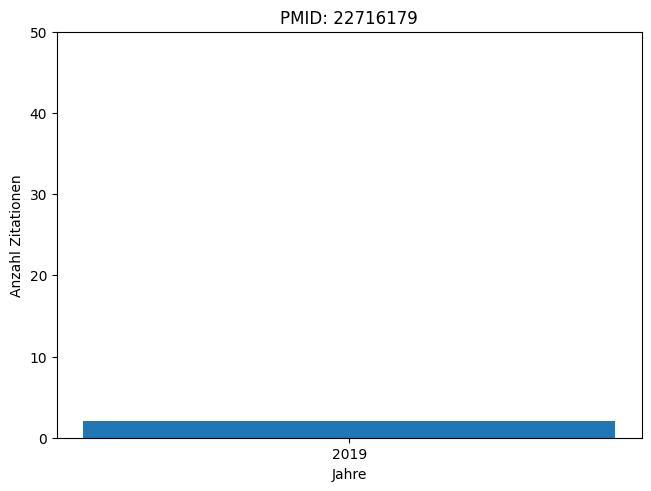

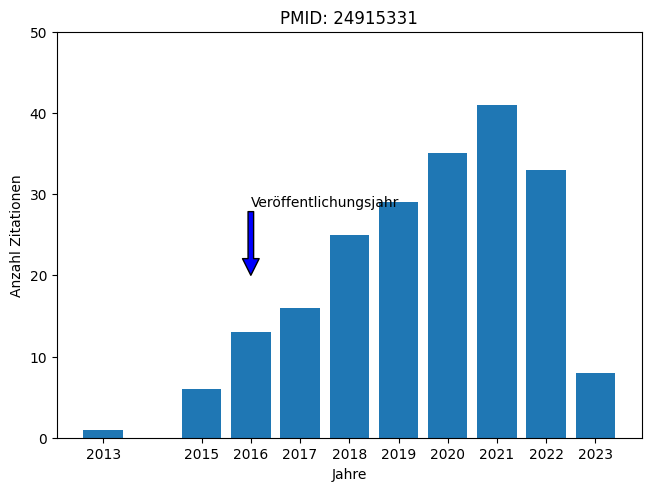

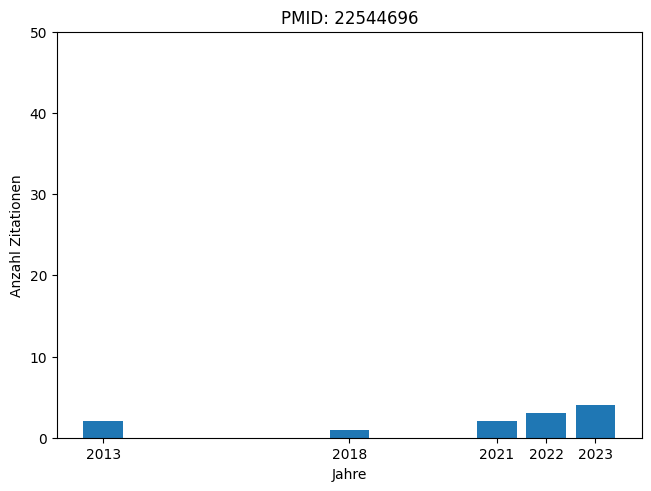

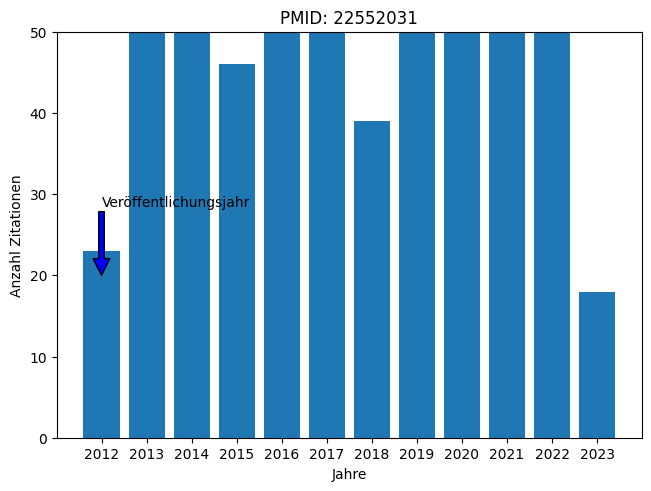

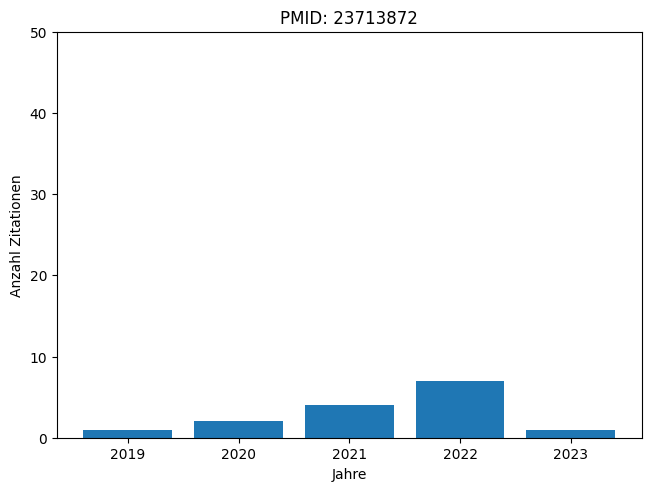

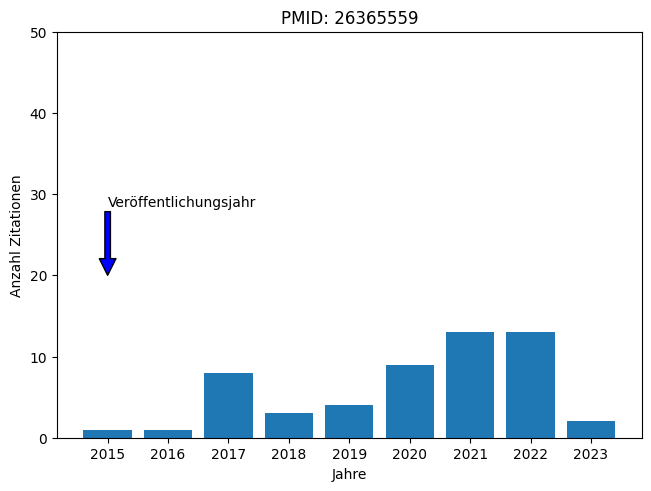

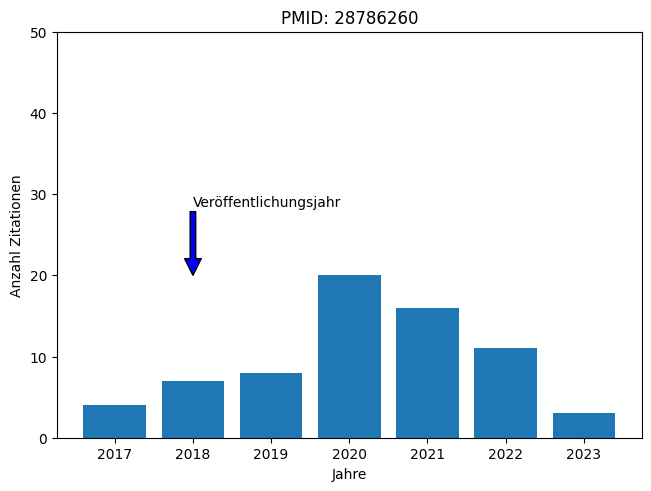

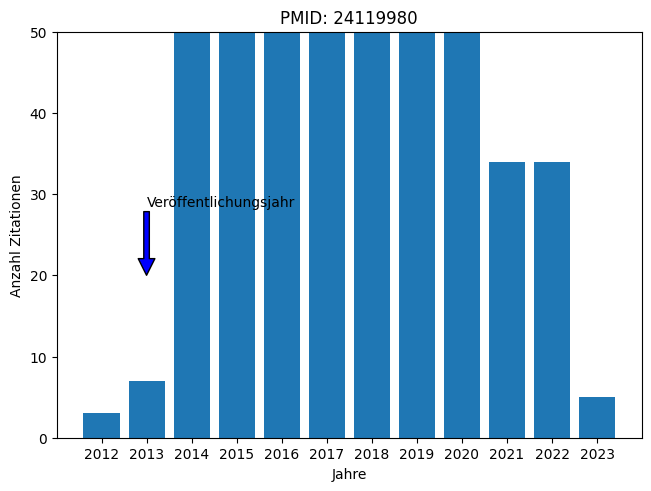

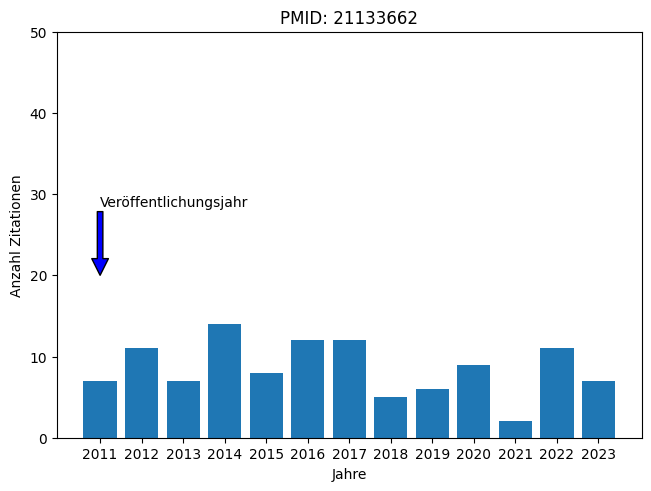

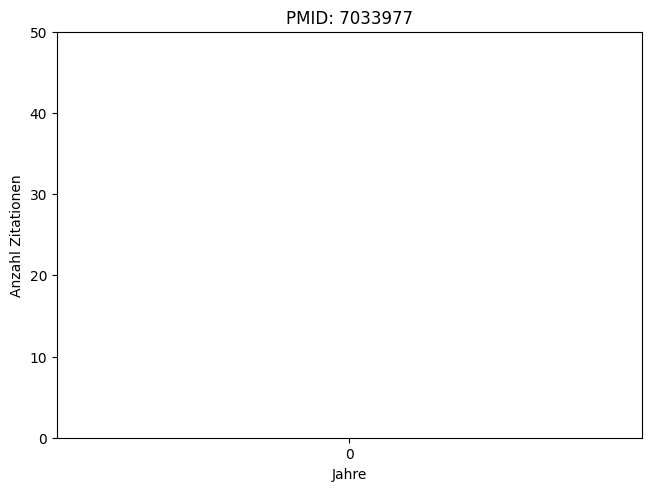

In [133]:
for id in idList:
    plotCitationsPerYear(id)